## Hello!
If you're here, you passed the test. You were curious enough to see the work that I did in bringing you my Persona 5R stats video. I hope I can be as helpful as possible through these annotations, but if anything was confusing or otherwise hard to understand, please drop a comment under the YouTube video. I'll try to clarify, and update this file in turn.

## Imports
This is me borrowing code from other people. I make heavy use of the infrastructure these imports provide to do my analysis. It's not incredibly important to know what each one does, so I'll leave that to you to find out.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import bs4
import requests

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

## Matplotlib Formatting
This cell formats the color scheme for the charts from the Matplotlib package. I use a colorblind-compatible colorscheme to try and make my work as accessible as possible. Besides, they look nice.

In [4]:
# colors from Tableau Colorblind 10
tableau_colorblind10 = [
    '#5f9ed1',
    '#006ba4',
    '#595959',
    '#898989',
    '#a2c8ac',
    '#ababab',
    '#c85200',
    '#cfcfcf',
    '#ff800e',
    '#ffbc79'
]

colors = {
    'background': tableau_colorblind10[2],
    'text': 'white',
    'fill': tableau_colorblind10[0]
}

style = {"axes.grid" : True,
         "axes.grid.axis" : "x",
         "axes.spines.top"  : False,
         "axes.spines.right"  : False,
         "axes.facecolor" : colors['background'],
         "figure.facecolor": colors['background'],
         "savefig.facecolor" : colors['background'],
         "grid.color" : colors['background'],
         "axes.edgecolor" : colors['text'],
         "text.color" : colors['text'],
         "xtick.color" : colors['text'],
         "ytick.color" : colors['text'],
         "ytick.left" : False,
         "xtick.bottom" : False,
         "font.size" : 14,
         }
plt.rcParams.update(style)

## Reading HTML
I grabbed a copy of the raw source from aqiu384's website to read in. In retrospect, it'd have been smarter to just go to their git repo to grab his spreadsheet straight from the source, but alas. 

In [ ]:
# first we get our web data
# saved from https://aqiu384.github.io/megaten-fusion-tool/p5r/personas on 2020/06/28
with open('list-of-personas.html') as f:
    personas_html = f.read()

## Beautiful Soup
The most popular python package for reading HTML is called Beautiful Soup. Your guess is as good as mine.

In [ ]:
# soupify
persona_soup = bs4.BeautifulSoup(personas_html, "html.parser")
table_raw = persona_soup.find('app-demon-list-container') # Find the personas table in the website
header, contents = table_raw.find_all('table')

## Reading In the Table
Once we find the table, we have to read it in. We strip each element using its html tag and manually re-add the headings.

In [ ]:
content_rows = contents.find('tbody').find_all('tr')
header_values = str.split("Arcana Lvl Name Inherits St Ma En Ag Lu Phys Gun Fire Ice Elec Wind Psi Nuke Bless Curse")

## Functions
When you need to repeat a bunch of steps, functions come in handy. I convert the data row by row using python's list comprehension; in other words, I get the data from the row for each row in the table.

In [ ]:
def get_data_from_tr(tr):
    entries = tr.find_all('td')
    row = {}
    for value, entry in zip(header_values, entries):
        row[value] = str.strip(entry.text)
    return row

persona_dict = {get_data_from_tr(tr)["Name"]: get_data_from_tr(tr) for tr in content_rows}
persona_dict["Pixie"]

## Sanity Check
This cell just checks to make sure the code above parsed the page correctly

In [ ]:
personas = list(persona_dict.keys())
personas.sort(key=lambda name: persona_dict[name]['Lvl'])
for i, key in enumerate(personas):
    print(i,"\t", key)

## Put it in a Table
The Pandas package allows you to convert dictionaries to DataFrames, which are very powerful objects for viewing and interacting with data.

I sort the values the way they would be listed in the game, and replace the non-numeric values for resistances with their numeric counterparts.

In [218]:
compendium = pd.DataFrame(persona_dict.values())
compendium.sort_values(by=['Lvl', 'Arcana'], inplace=True)
compendium.replace({'rs':0.5, 'wk':2, 'no':'', 'nu':0, 'rp':-1}, inplace=True)
compendium.head()

,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,Phys,Gun,Fire,Ice,Elec,Wind,Psi,Nuke,Bless,Curse
13,Fool,1,Arsene,curse,2,2,2,3,1,,,,2,,,,,2,0.5
25,Magician P,1,Zorro,wind,2,3,1,3,1,,,,,2,0.5,,,,
80,Chariot,10,Slime,curse,9,6,11,6,5,0.5,0.5,2,,,2,,,,
54,Emperor,10,Regent,almighty,10,10,10,10,10,0.5,0.5,,,,,,2,,
22,Magician,11,Jack Frost,ice,8,9,7,9,7,,,2,0,,,,,,


## Saving Our Progress
I save the dataframe to a csv file so I never have to do that again.

In [219]:
compendium.to_csv("compendium-nosrc.csv") # compendium without cultural source

## Reading from the Wiki
I'm going to ask you not to run this code. It's the code that attempts to obtain persona information from the Wiki. Hitting a site with 200+ requests is generally not nice. When it was just me doing it, there wasn't a huge problem. But if everybody viewing my video does it, the site could be put under heavy load, causing its owners to have to pay extra money. Look, don't touch!

In [ ]:
"""
def format_name_for_site(persona_name):
    cut_dashes = persona_name.replace("-", " ")
    indiv_words = cut_dashes.split(" ")
    return "_".join(indiv_words)
format_name_for_site("Emperor's Amulet")
# break
base_site_name = "https://megamitensei.fandom.com/wiki/"
site_data = {}
for persona in compendium.Name:
    site = base_site_name + format_name_for_site(persona)
    pagereq = requests.get(site)
    site_data[persona] = bs4.BeautifulSoup(pagereq.text, "html.parser")
site_data["Jack Frost"]
# break
def extract_source(soup):
    try:
        return ", ".join([a.text for a in soup.find("div", attrs={"data-source":"origin"}).find("div").find_all("a")])
    except:
        return "Not Found"
extract_source(site_data["Arsene"]), extract_source(site_data["Jack Frost"]), extract_source(site_data["Pixie"])
# break
sources = pd.DataFrame([{'Name':persona, 'Source':extract_source(site_data[persona])} for persona in compendium.Name])
sources.head()
# break
sources.groupby("Source").count()
"""

## Numerical Replacements for Arcana
This exists pretty much just to sort the DataFrame.

In [21]:
arcana_numbers = {
    'Fool': 0,
    'Magician': 1,
    'Priestess': 2,
    'Empress': 3,
    'Emperor': 4,
    'Hierophant': 5,
    'Lovers': 6,
    'Chariot': 7,
    'Justice': 8,
    'Hermit': 9,
    'Fortune': 10,
    'Strength': 11,
    'Hanged': 12,
    'Death': 13,
    'Temperance': 14,
    'Devil': 15,
    'Tower': 16,
    'Star': 17,
    'Moon': 18,
    'Sun': 19,
    'Judgement': 20,
    'Faith': 21,
    'Councillor': 22,
    'World': 23
}

## The Real Actual Data
It was at this point I did my manual data entry. It was hard, painful, but worst of all, repetitive and boring. I suffered so you don't have to. Please feel free to use this csv.

In [7]:
compendium = pd.read_csv("persona-compendium.csv")
compendium.fillna("", inplace=True)
compendium['Arcana_Number'] = compendium.Arcana.replace(arcana_numbers)
compendium = compendium.sort_values(by=['Arcana_Number', 'Lvl', 'Name']).reset_index()
column_reorder = str.split("Arcana_Number Arcana Lvl Name Inherits St Ma En Ag Lu Phys Gun Fire Ice Elec Wind Psi Nuke Bless Curse Region Type")
compendium = compendium[column_reorder]
compendium.head()

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Fire,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type
0,0,Fool,1,Arsene,curse,2,2,2,3,1,...,,2,,,,,2,0.5,FR,LIT
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,,2,,,,,,JP,MYTH
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,,0.5,0.5,,2,,,UK,MYTH
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,,0.5,2,,,,0,JP,MYTH
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,,0,2,,,,0,JP,MYTH


## List the Number of Personas Per Region

In [231]:
compendium.groupby("Region").count().max(axis=1)

Region
AB    35
AR     1
AU     2
BH     7
CH     8
EG     5
EU     6
FR     4
GO    10
GR    26
HA     1
HI    24
ID     2
IR     6
JP    45
MS     4
NM     2
NO     9
P5     9
SL     1
SP     1
UK    16
US     8
ZA     3
dtype: int64

## Print Personas from a Region
Please, interact with this cell! You can change the value in quotes to choose a new region, then run the cell with Shift+Enter to list all the personas from that region! The above cell lists all the different valid region codes.

In [23]:
region_code = 'SL' # edit this value in quotes to change the output
compendium[compendium.Region == region_code]

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type,Outliers
146,13,Death,62,Chernobog,ailment,40,37,39,38,39,...,ab,0,,,,2,ab,SL,MYTH,0


## Charts
Making the persona stat charts was more annoying than difficult. Matplotlib is extremely versitile, but that also makes configuring it something of a trial. I only had to do it once, though, so I can take solace in that.

Try using my function to print persona stats, like I do at the end of this cell!

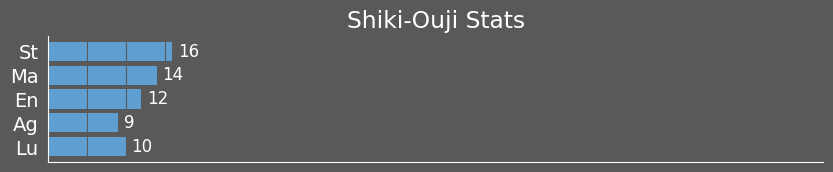

In [12]:
"""
Let's get a visual representation of persona stats going.
"""

STATS = str.split('St Ma En Ag Lu')
get_stats = lambda row: row[STATS]
lookup = lambda persona: compendium.loc[compendium.Name == persona].iloc[0]

def plot_stats(row):
    stats = get_stats(row)
    val = list(stats)
    lbl = list(stats.index)
    lbl.reverse()
    val.reverse()
    title = row.Name + " Stats"
    fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
    plt.title(title)
    #fig.tight_layout()
    fig.subplots_adjust(bottom=0.25)
    ax.set_xlim(0, 100)
    plt.xticks(range(0, 100, 5), labels=[])
    plt.barh(lbl, val, color=colors['fill'])
    for i,j in zip(lbl, val):
        ax.annotate(j, xy=(j,i), xytext=(4, 0),textcoords='offset points', va="center", size=12)
    plt.show()

plot_stats(lookup("Shiki-Ouji")) # Change what gets displayed here!

## Getting Stats
This is the offending cell. Here is where we acquire outlier data, as well as other useful stats. Try looking up stats for your favorite persona!

In [13]:
def stat_data(persona):
    stats = get_stats(lookup(persona))
    avg, std = stats.mean(), stats.std()
    outlier_cutoff = stats.median()*1.1 #stats.mean() + (stats.std() * 2) 
    outliers = stats[stats > outlier_cutoff]
    return persona, avg, std, outliers 
stat_data('Shiki-Ouji')

('Shiki-Ouji',
 12.2,
 2.8635642126552705,
 St    16
 Ma    14
 Name: 76, dtype: object)

## Adding the Data
In this cell, we make a new column that contains the count of outliers for each persona. The first line makes a function to grab what we need; the second makes a column using that function; the third adds the column to the DataFrame.

In [14]:
"""
Now to make our stat cats! We want to decide on some number of archetypes and how to classify them.
Ex: Phys Bruiser would have St + Agi, balanced would have all stats near the same.
Perhaps even more broad cats? Like balanced vs 1 high vs 2 high? We can likely do both.
"""
get_num_outliers = lambda persona: len(stat_data(persona)[3])
outliers = compendium.Name.apply(get_num_outliers)
compendium['Outliers'] = outliers
compendium

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type,Outliers
0,0,Fool,1,Arsene,curse,2,2,2,3,1,...,2,,,,,2,0.5,FR,LIT,1
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,2,,,,,,JP,MYTH,2
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,0.5,0.5,,2,,,UK,MYTH,2
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,0.5,2,,,,0,JP,MYTH,0
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,0,2,,,,0,JP,MYTH,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,22,Councillor,44,Ananta,nuke,26,30,31,27,25,...,ab,2,,,,,,HI,MYTH,2
231,22,Councillor,57,Yatagarasu,fire,35,41,30,40,32,...,,,0.5,,,0,2,JP,MYTH,2
232,22,Councillor,62,Seiryu,ice,38,41,43,37,34,...,0.5,,,,2,,,CH,MYTH,1
233,22,Councillor,71,Dionysus,ailment,42,48,44,42,44,...,,-1,,,,0,0,GR,MYTH,0


## Stat Lookup
You can change the query to display both a persona's stats and the number of outliers it has.

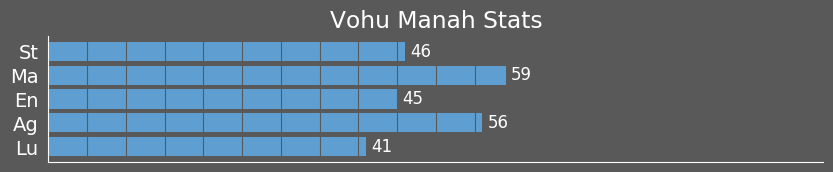

2

In [15]:
query = 'Vohu Manah'
plot_stats(lookup(query))
get_num_outliers(query)

## Cutting Things Up to Size
Here I cut out the groups with too few personas, and print out the groups that remain.

In [240]:
# We want some minimum value for an adequate sample.
MIN_SIZE = 5
counts = compendium.groupby("Region").count().max(axis=1)
selected_counts = counts[counts >= MIN_SIZE]
target_regions = list(selected_counts.index)
target_regions

['AB',
 'BH',
 'CH',
 'EG',
 'EU',
 'GO',
 'GR',
 'HI',
 'IR',
 'JP',
 'NO',
 'P5',
 'UK',
 'US']

## Sanity Check
Just making sure the compendium is ok. Also, checking how many we keep.

In [241]:
# compendium with only regions with MIN_SIZE or more elements
cut_compendium = compendium[compendium.Region.isin(target_regions)]
print("Percentage of personas kept:", len(cut_compendium) / len(compendium))
cut_compendium.head()

Percentage of personas kept: 0.9106382978723404


,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type,Outliers
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,2,,,,,,JP,MYTH,2
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,0.5,0.5,,2,,,UK,MYTH,2
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,0.5,2,,,,0,JP,MYTH,0
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,0,2,,,,0,JP,MYTH,0
5,0,Fool,26,Orpheus,almighty,17,17,17,17,17,...,,2,,,,0.5,2,GR,MYTH,0


## Basic Data
Just printing out the stats for everything to check if we can find something interesting. We can't.

In [242]:
cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Region,,,
AB,35,0.885714,0.795998
BH,7,1.285714,0.487950
CH,8,0.875000,0.640870
EG,5,0.800000,0.836660
EU,6,1.500000,0.836660
GO,10,1.000000,0.816497
GR,26,1.115385,0.816182
HI,24,1.083333,0.880547
IR,6,1.333333,0.816497


## Simplifying the output
I explicitly remove the gems here to help illustrate my point. I guess, ironically, the gems ended up being the only group with a definitive difference from the rest.

In [243]:
eda = cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].drop('P5').min()), (eda["std"].max() - eda["std"].drop('P5').min())

(0.7, 0.39259656583624125)

## More Restrictive Cutting
I tried to rectify the problem by forcing my sample size up. Not only did this dramatically increase the number of personas cut from the roster, it didn't solve the problem. Because this is just a repeat of the above few cells, I'll skip down a few.

In [ ]:
# try again with larger groups, for bigger sample size
# We want some minimum value for an adequate sample.
MIN_SIZE = 10
counts = compendium.groupby("Region").count().max(axis=1)
selected_counts = counts[counts >= MIN_SIZE]
target_regions = list(selected_counts.index)
# compendium with only regions with MIN_SIZE or more elements
cut_compendium = compendium[compendium.Region.isin(target_regions)]
print("Percentage of personas kept:", len(cut_compendium) / len(compendium))
print(target_regions)
cut_compendium.head()

In [ ]:
cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])

In [ ]:
eda = cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].min()), (eda["std"].max() - eda["std"].min())

## Shifting Gears
Here's where I check type. It immediately goes wrong, as I explained in the video.

In [244]:
#hmm... let's try type
compendium.groupby("Type").count().max(axis=1)

Type
HIST      7
LIT      11
MYTH    205
P5        9
POP       3
dtype: int64

## If you were curious what the stats looked like
here they are. They're not great.

In [245]:
#everything is from mythology. This would be something of a waste of time. Let's do it anyway
compendium.groupby("Type")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Type,,,
HIST,7,1.571429,0.534522
LIT,11,1.363636,0.674200
MYTH,205,1.087805,0.793415
P5,9,0.000000,0.000000
POP,3,1.000000,1.000000


In [ ]:
# could be interesting, but sample sizes are wayyyyyyyy too low.

## Arcana
This I really thought would have some sort of glaring difference. Unfortunately it was only slightly more promising than the alternatives. Slightly is better than nothing, though.

In [246]:
# Only one avenue left... Arcana?
compendium.groupby("Arcana")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Arcana,,,
Chariot,10,1.400000,0.966092
Councillor,8,1.125000,0.991031
Death,13,1.461538,0.776250
Devil,9,1.111111,0.600925
Emperor,10,0.800000,0.918937
Empress,10,0.900000,0.737865
Faith,10,1.200000,0.632456
Fool,14,0.714286,0.825420
Fortune,11,1.545455,0.687552


## The same stat check here

In [247]:
eda = compendium.groupby("Arcana")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].min()), (eda["std"].max() - eda["std"].min())

(0.9333333333333335, 0.49103120896511476)

## The Linear Regression
Scikit (and statsmodel) allow you to run complex regressions near instantly. While I could code them myself, if I wasn't going to explain how they worked in the video there wouldn't be any point.

The below cell is intentionally wrong. That's because there's something called the "dummy variable effect" where if you include a boolean variable for every possibility, the regression breaks. It's pretty interesting and I suggest really sitting down and figuring out why it exists sometime.

In [248]:
# We could run an ANOVA - but there's so many groups and so few members per groups
# Maybe we could run a linear classifier? then use the coefficients to divine information

X = pd.get_dummies(compendium.Arcana)
y = compendium.Outliers
reg = LinearRegression().fit(X, y)

results = pd.DataFrame(zip(X.columns, reg.coef_), columns=["Arcana", "coeff"])
display(results)

,Arcana,coeff
0,Chariot,7.627935e+12
1,Councillor,7.627935e+12
2,Death,7.627935e+12
3,Devil,7.627935e+12
4,Emperor,7.627935e+12
5,Empress,7.627935e+12
6,Faith,7.627935e+12
7,Fool,7.627935e+12
8,Fortune,7.627935e+12
9,Hanged,7.627935e+12


## Linear Regression, for real this time
Now for the actual results. You might notice that summing the coefficients with the baseline - in this case 1.4, the average for the Chariot Arcana - results in the same mean from a few cells ago. That is a result of the type of regression we used - Least Squares Regression.

In [249]:
# Uh, that's not right
# Try again, avoiding the dummy variable trap
X = pd.get_dummies(compendium.Arcana, drop_first=True)
y = compendium.Outliers
reg = LinearRegression().fit(X, y)

results = pd.DataFrame(zip(X.columns, reg.coef_), columns=["Arcana", "coeff"])
results = results.append({'Arcana':'Chariot', 'coeff': 0}, ignore_index=True).sort_values(by='coeff', ascending=False).reset_index(drop=True)
display(results)
reg.intercept_

,Arcana,coeff
0,Lovers,0.200000
1,Fortune,0.145455
2,Moon,0.061538
3,Death,0.061538
4,Chariot,0.000000
5,Faith,-0.200000
6,Hermit,-0.246154
7,Councillor,-0.275000
8,Devil,-0.288889
9,Star,-0.288889


1.4000000000000015

## Statsmodel
If I knew this existed I'd've used it for this project from the start. I almost calculated all this information on my own, without any mechanism to explain it to you guys,

###p-value
I feel obligated to explain this breifly, since I did such a poor job of it in my video. The first thing is when you run a statistical experiment you have two hypotheses - the "null hypothesis" and the "alternative hypothesis." Usually the alternative hypothesis is there is some correlation between the variables you're measuring, and the null is that no such correlation exists. The p-value represents the probability that the data you've collected would appear under the null. If that's hard to understand, Don't worry, most stats courses I've taken spend at least a lecture on the concept.

In [250]:
reg = sm.OLS(y, sm.add_constant(X))
reg = reg.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Outliers   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.319
Date:                Wed, 30 Sep 2020   Prob (F-statistic):              0.161
Time:                        15:15:52   Log-Likelihood:                -265.44
No. Observations:                 235   AIC:                             576.9
Df Residuals:                     212   BIC:                             656.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4000      0.249      5.616      0.000       0.909       1.891
Councillor    -0.2750      0.374     -0.735      0.463      -1.012       0.462
Death          0.0615      0.332      0.186      0.853      -0.592       0.715
Devil         -0.2889      0.362     -0.798      0.426      -1.003       0.425
Emperor       -0.6000      0.353     -1.702      0.090      -1.295       0.095
Empress       -0.5000      0.353     -1.418      0.158      -1.195       0.195
Faith         -0.2000      0.353     -0.567      0.571      -0.895       0.495
Fool          -0.6857      0.326     -2.101      0.037      -1.329      -0.042
Fortune        0.1455      0.344      0.422      0.673      -0.533       0.824
Hanged        -0.4000      0.353     -1.135      0.258      -1.095       0.295
Hermit        -0.2462      0.332     -0.742      0.459      -0.900       0.407
Hierophant    -0.4000      0.388     -1.030      0.304      -1.166       0.366
Judgement     -0.7333      0.362     -2.025      0.044      -1.447      -0.019
Justice       -0.6727      0.344     -1.953      0.052      -1.352       0.006
Lovers         0.2000      0.353      0.567      0.571      -0.495       0.895
Magician      -0.4000      0.338     -1.185      0.237      -1.065       0.265
Moon           0.0615      0.332      0.186      0.853      -0.592       0.715
Priestess     -0.6000      0.353     -1.702      0.090      -1.295       0.095
Star          -0.2889      0.362     -0.798      0.426      -1.003       0.425
Strength      -0.5000      0.353     -1.418      0.158      -1.195       0.195
Sun           -0.5250      0.374     -1.404      0.162      -1.262       0.212
Temperance    -0.5111      0.362     -1.411      0.160      -1.225       0.203
Tower         -0.4000      0.362     -1.104      0.271      -1.114       0.314
==============================================================================
Omnibus:                       40.359   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.445
Skew:                          -0.148   Prob(JB):                      0.00540
Kurtosis:                       2.010   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## You've Made it to The End
Thanks for reading! Now go and do your own analysis! It's 1 am, I'm going to bed.